# U.S. Presidential Election - State Level

## Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import requests
import lxml.html as lh

import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

import networkx as nx
import plotly.graph_objects as go

sys.path.append('..')
from lmapper.filter import Projection
from lmapper.filter import Filter

from lmapper.cutoff import FirstGap

from utils import get_node_size, get_mean_node, get_mapper
from filters import SvdFilter, LpFilter
from plotting import mapper_nx_plot, mapper_plotly_plot

../lmapper/cpp/filterutils


The Python implementation of the eccentricity is used instead, but it will be slower.
The scipy.distance.cdist implementation is used instead.


In [2]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           ["blue", "violet", "red"])
cmap_inv = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                               ["red", "violet", "blue"])

## Data

In [3]:
df = (pd.read_pickle(os.path.join('data',
                                  'usa_election_full_dataset.pickle'))
      .drop(columns=['county', 'winner', 'fips', 'pres'])
      .groupby(['year', 'state'])
      .sum()
      .dropna()
      .reset_index())
df['winner'] = (df['republican'] > df['democrat']).astype('int')

num_cols = ['Personal income (thousands of dollars)',
            'Net earnings by place of residence',
            'Personal current transfer receipts',
            'Income maintenance benefits 1/',
            'Unemployment insurance compensation',
            'Retirement and other',
            'Dividends, interest, and rent 2/',
            'Population (persons) 3/',
            'Per capita personal income 4/',
            'Per capita net earnings 4/',
            'Per capita personal current transfer receipts 4/',
            'Per capita income maintenance benefits 4/',
            'Per capita unemployment insurance compensation 4/',
            'Per capita retirement and other 4/',
            'Per capita dividends, interest, and rent 4/',
            'Earnings by place of work',
            'Wages and salaries',
            'Supplements to wages and salaries',
            'Employer contributions for employee pension and insurance funds 5/',
            'Employer contributions for government social insurance',
            "Proprietors' income",
            "Farm proprietors' income",
            "Nonfarm proprietors' income",
            'Total employment (number of jobs)',
            'Wage and salary employment',
            'Proprietors employment',
            'Farm proprietors employment 6/',
            'Nonfarm proprietors employment',
            'Average earnings per job (dollars)',
            'Average wages and salaries',
            "Average nonfarm proprietors' income"]

info_cols = ['year', 'state']


elec_cols = ['republican', 'democrat', 'total_votes',
             'winner']



df = df[info_cols + elec_cols + num_cols]
df.head()

year       state  republican   democrat  total_votes  winner  \
0  2000     Alabama    944409.0   695602.0    1672551.0       1   
1  2000     Arizona    781652.0   685341.0    1534113.0       1   
2  2000    Arkansas    472940.0   422768.0     921781.0       1   
3  2000  California   4567429.0  5861203.0   10965856.0       0   
4  2000    Colorado    883745.0   738227.0    1741365.0       1   

   Personal income (thousands of dollars)  Net earnings by place of residence  \
0                            1.083551e+08                          70349092.0   
1                            1.353875e+08                          89896128.0   
2                            6.096988e+07                          39153406.0   
3                            1.133965e+09                         797225593.0   
4                            1.479249e+08                         105834960.0   

   Personal current transfer receipts  Income maintenance benefits 1/  ...  \
0                          17749697.0                       1919785.0  ...   
1                          17027888.0                       1514425.0  ...   
2                          10741397.0                       1123407.0  ...   
3                         122177543.0                      19428921.0  ...   
4                          12048738.0                       1070512.0  ...   

   Farm proprietors' income  Nonfarm proprietors' income  \
0                  811829.0                    7238067.0   
1                  438701.0                    9029023.0   
2                 1434102.0                    4461042.0   
3                 3601763.0                  117261113.0   
4                  384629.0                   13497426.0   

   Total employment (number of jobs)  Wage and salary employment  \
0                          2392225.0                   2008801.0   
1                          2801510.0                   2332044.0   
2                          1482449.0                   1210817.0   
3                         19228895.0                  15621983.0   
4                          2918002.0                   2331747.0   

   Proprietors employment  Farm proprietors employment 6/  \
0                383424.0                         48927.0   
1                469466.0                          7295.0   
2                271632.0                         49482.0   
3               3606912.0                         88324.0   
4                586255.0                         29601.0   

   Nonfarm proprietors employment  Average earnings per job (dollars)  \
0                        334497.0                           1856887.0   
1                        462171.0                            455623.0   
2                        222150.0                           1967107.0   
3                       3518588.0                           2093535.0   
4                        556654.0                           1759844.0   

   Average wages and salaries  Average nonfarm proprietors' income  
0                   1663493.0                            1076886.0  
1                    398684.0                             232966.0  
2                   1694531.0                            1301301.0  
3                   1798615.0                            1706070.0  
4                   1611705.0                            1150129.0  

[5 rows x 37 columns]

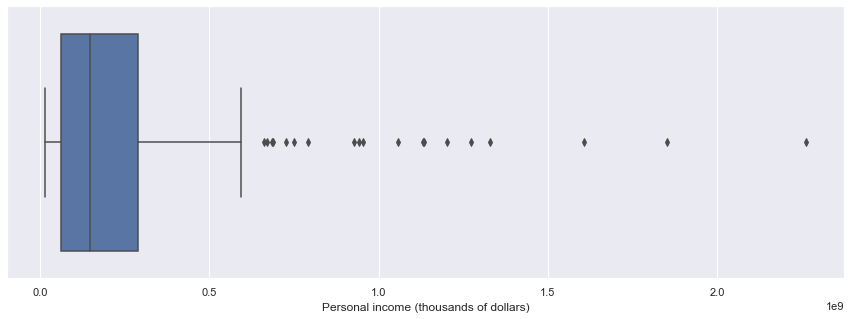

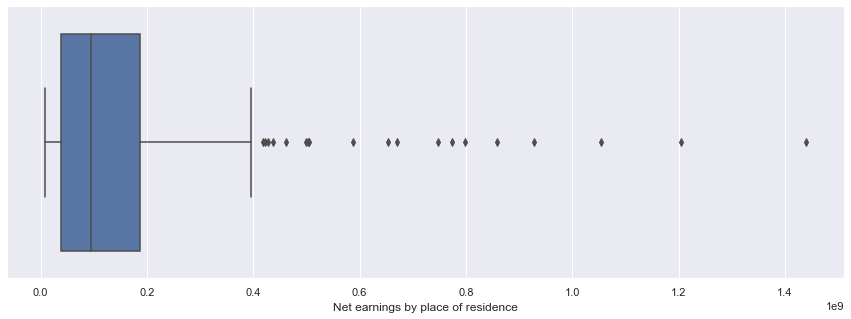

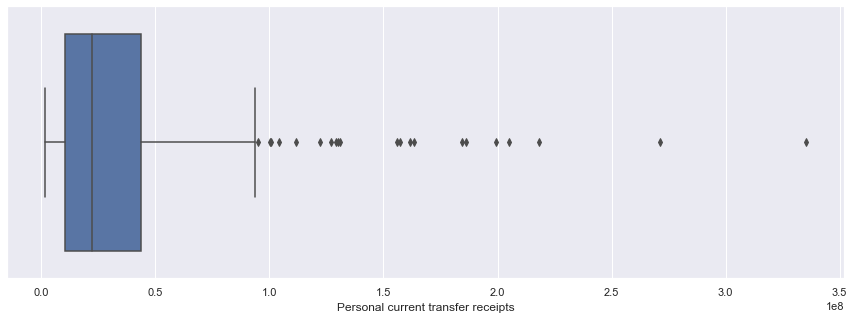

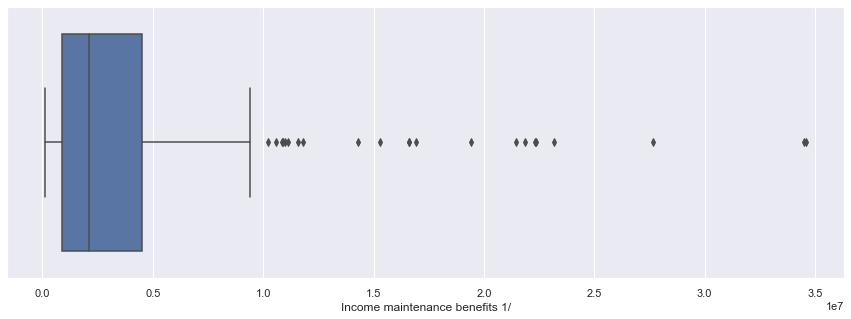

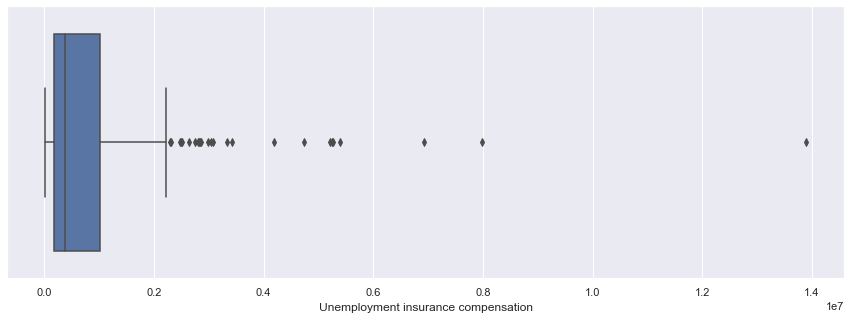

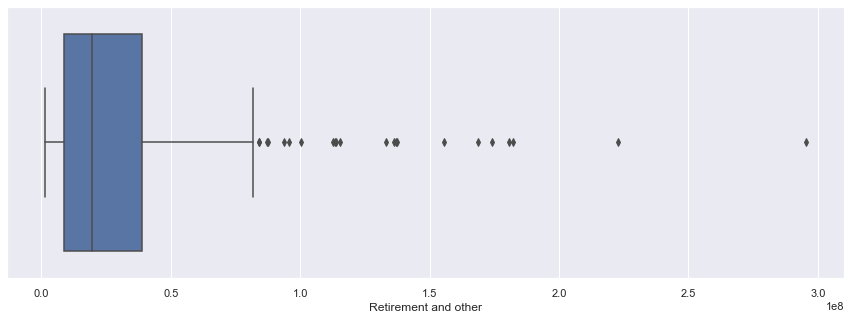

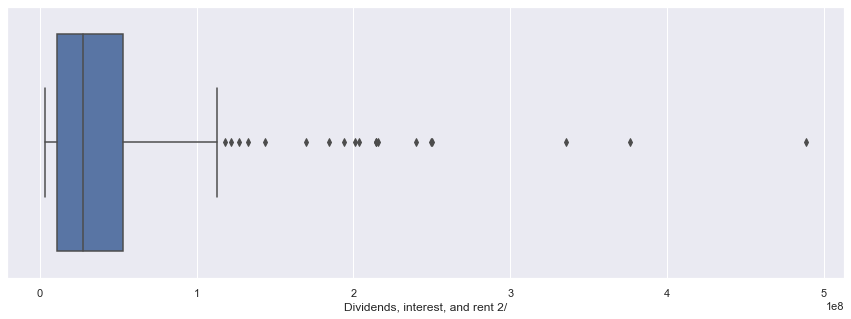

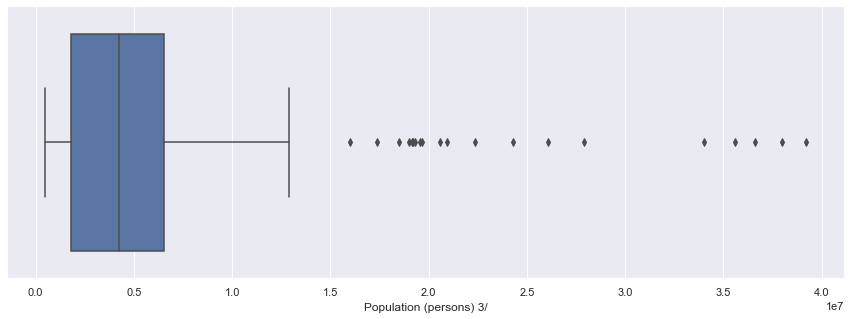

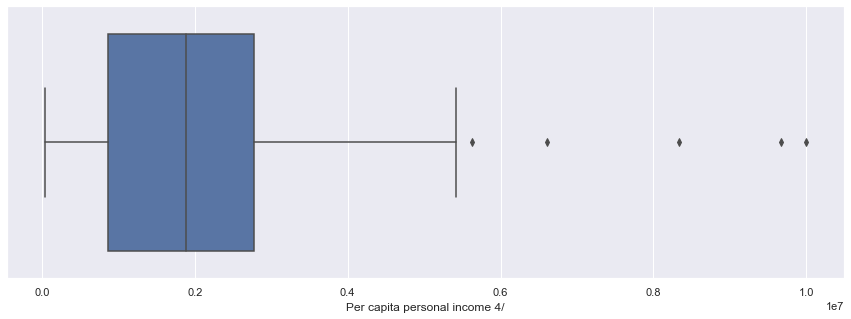

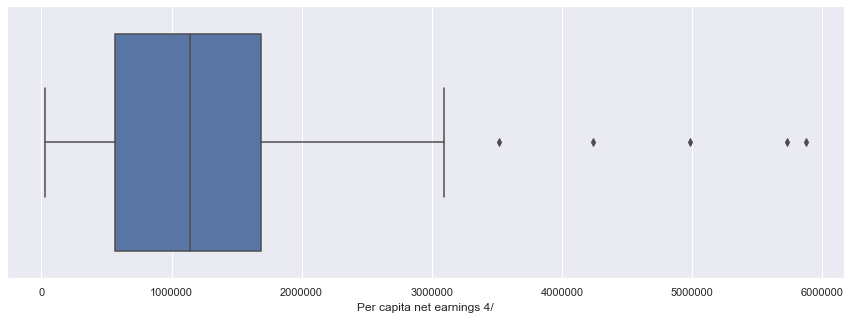

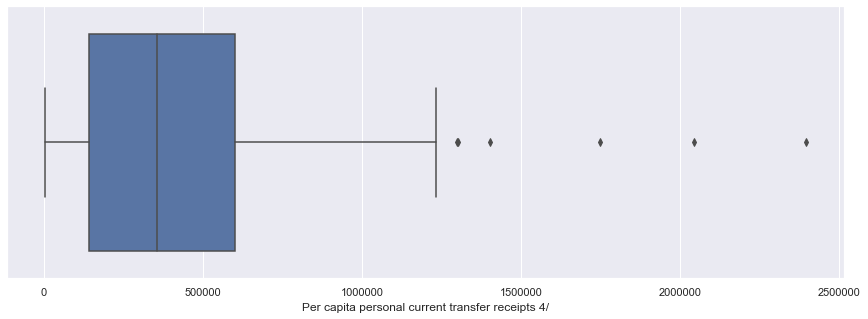

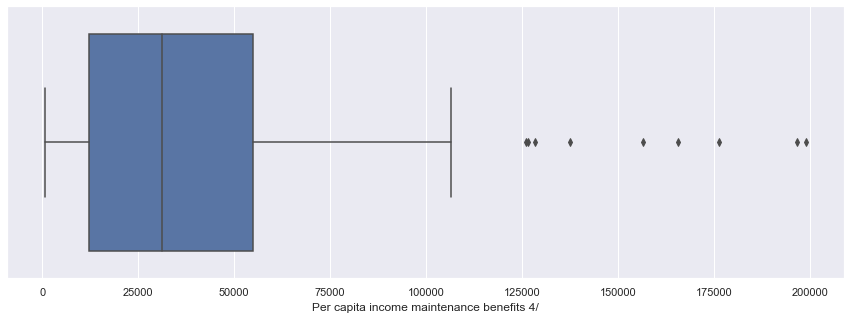

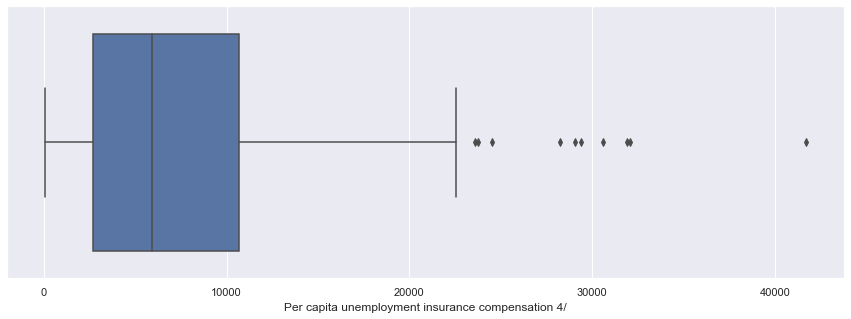

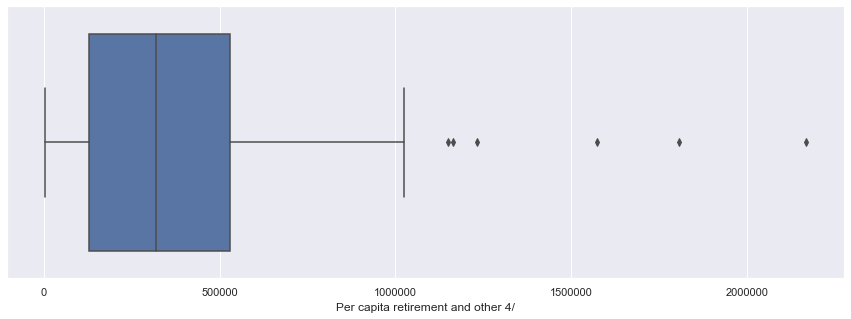

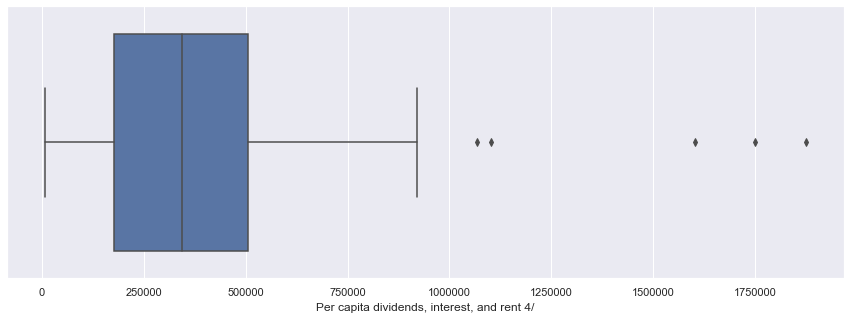

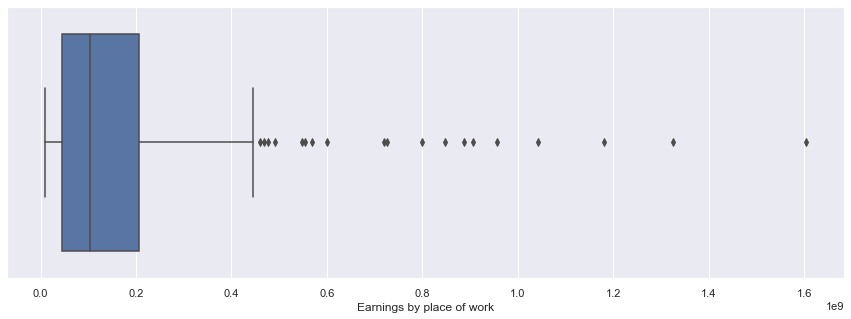

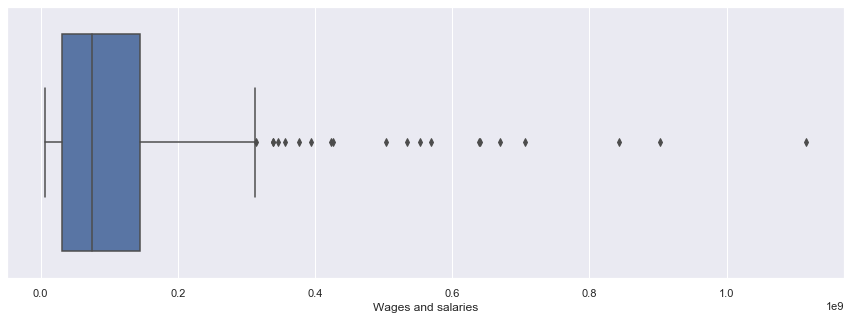

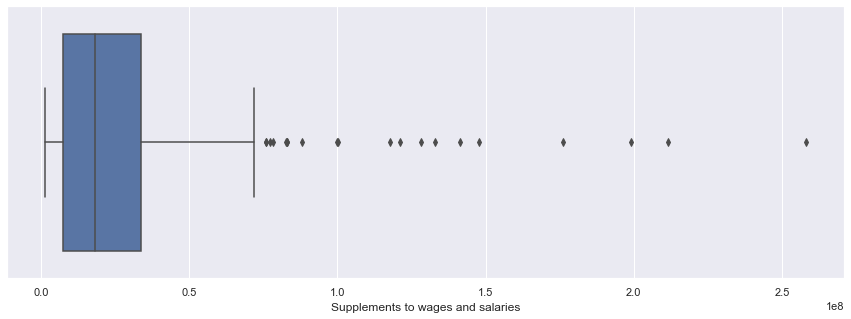

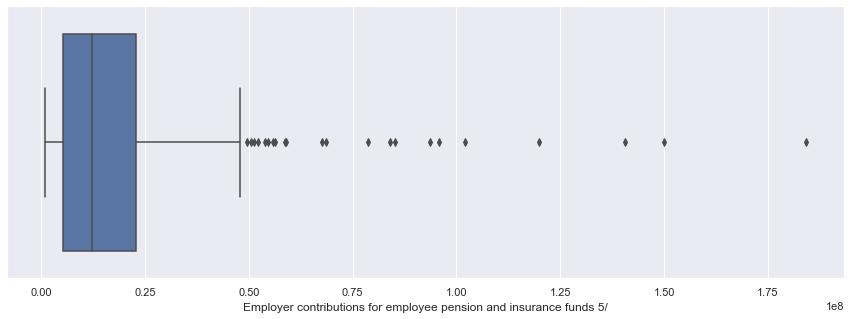

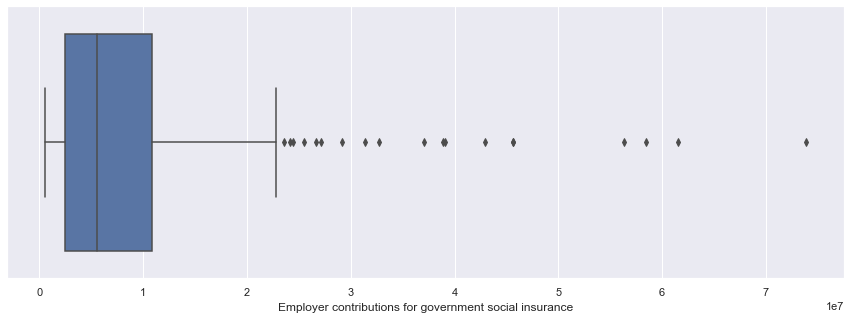

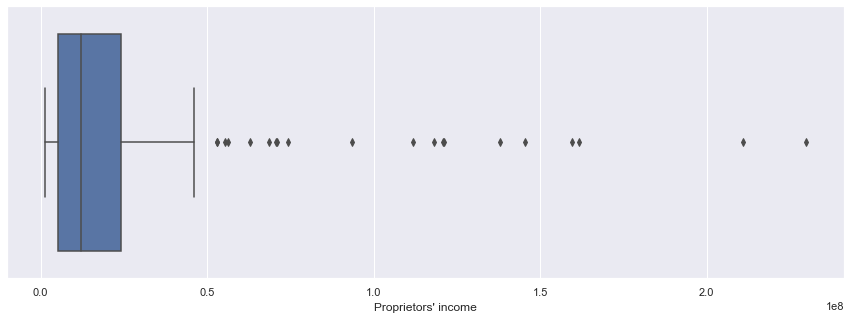

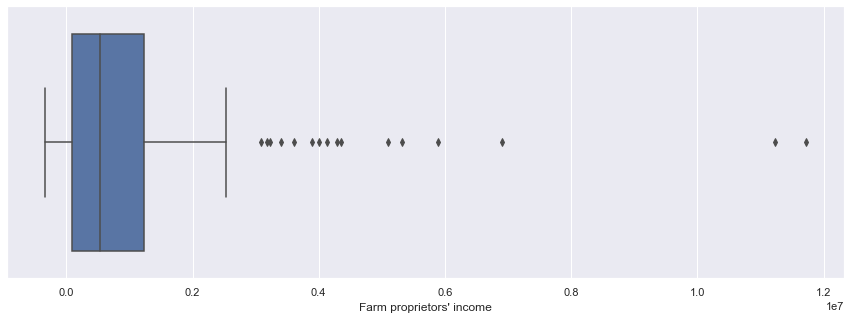

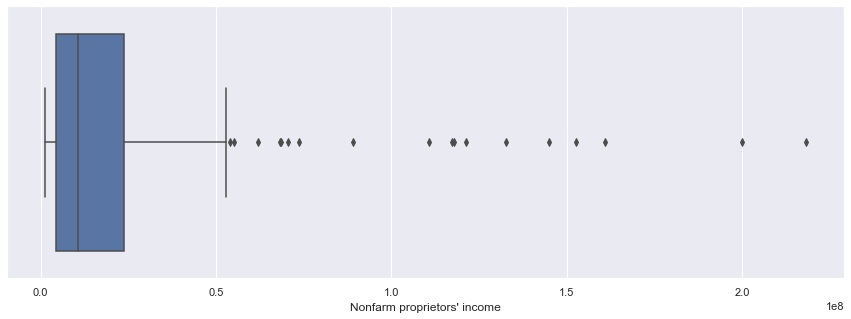

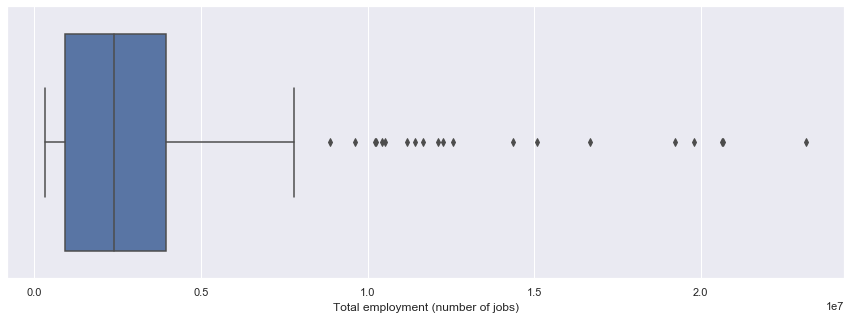

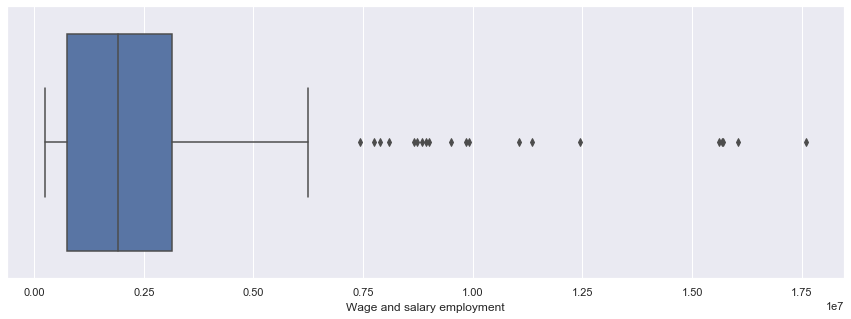

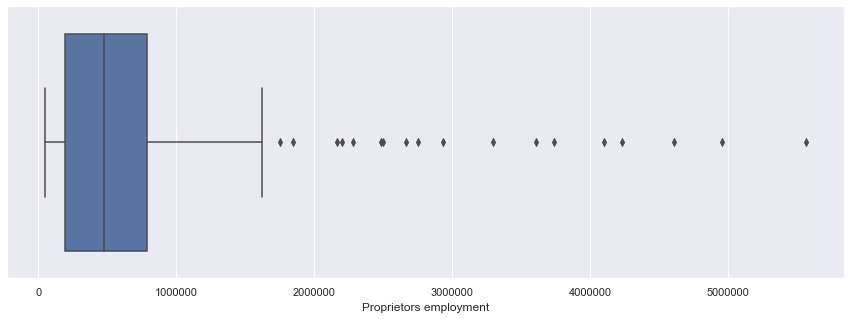

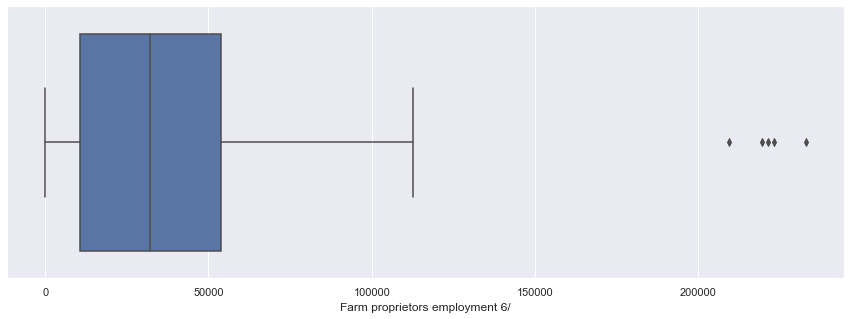

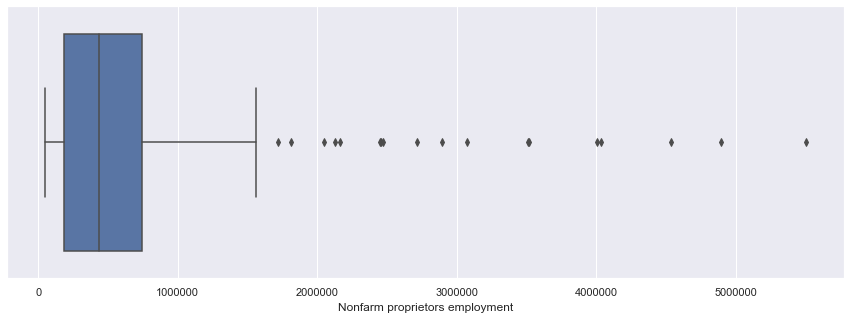

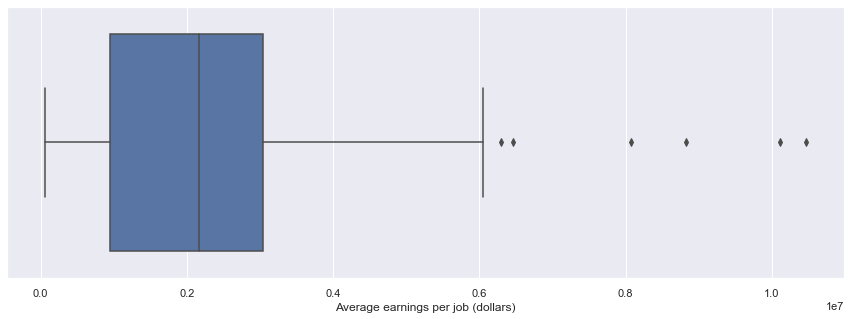

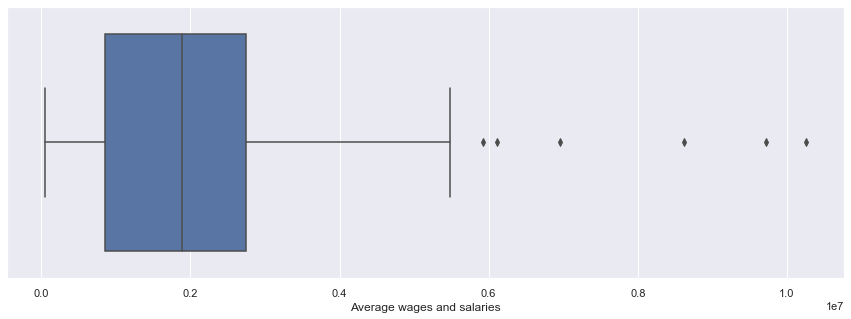

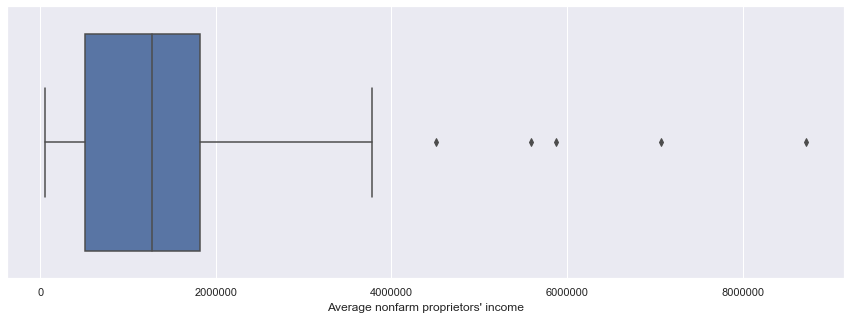

In [4]:
for col in num_cols:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=df[col])

In [5]:
df[num_cols] = (df[num_cols] + abs(df[num_cols].min().min()) + 1).apply(np.log)
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

year       state  republican   democrat  total_votes  winner  \
0  2000     Alabama    944409.0   695602.0    1672551.0       1   
1  2000     Arizona    781652.0   685341.0    1534113.0       1   
2  2000    Arkansas    472940.0   422768.0     921781.0       1   
3  2000  California   4567429.0  5861203.0   10965856.0       0   
4  2000    Colorado    883745.0   738227.0    1741365.0       1   

   Personal income (thousands of dollars)  Net earnings by place of residence  \
0                               -0.235045                           -0.229391   
1                               -0.022756                            0.001684   
2                               -0.782365                           -0.780420   
3                                2.006499                            2.064110   
4                                0.061691                            0.155636   

   Personal current transfer receipts  Income maintenance benefits 1/  ...  \
0                           -0.187465                       -0.138613  ...   
1                           -0.226152                       -0.347182  ...   
2                           -0.653124                       -0.597200  ...   
3                            1.629620                        2.145159  ...   
4                           -0.547151                       -0.636090  ...   

   Farm proprietors' income  Nonfarm proprietors' income  \
0                  0.269232                    -0.411684   
1                 -0.062685                    -0.205441   
2                  0.634644                    -0.855531   
3                  1.308686                     2.252777   
4                 -0.123806                     0.173595   

   Total employment (number of jobs)  Wage and salary employment  \
0                           0.025734                    0.068446   
1                           0.198578                    0.233243   
2                          -0.476017                   -0.462547   
3                           2.460887                    2.514500   
4                           0.243655                    0.233101   

   Proprietors employment  Farm proprietors employment 6/  \
0               -0.315923                        0.361512   
1               -0.113762                       -0.926824   
2               -0.618270                        0.377724   
3                2.724128                        1.457614   
4                0.128457                       -0.218157   

   Nonfarm proprietors employment  Average earnings per job (dollars)  \
0                       -0.368710                            0.083502   
1                       -0.057521                           -1.368579   
2                       -0.696316                            0.153339   
3                        2.749292                            0.229439   
4                        0.142134                            0.019041   

   Average wages and salaries  Average nonfarm proprietors' income  
0                    0.081442                             0.028733  
1                   -1.385244                            -1.422278  
2                    0.103989                             0.263645  
3                    0.177158                             0.615597  
4                    0.043029                             0.109277  

[5 rows x 37 columns]

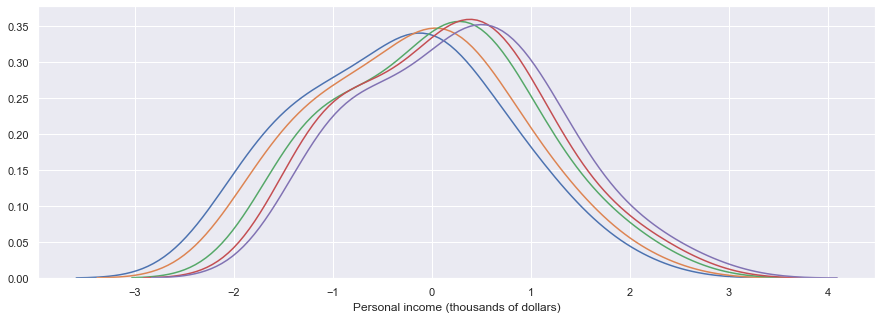

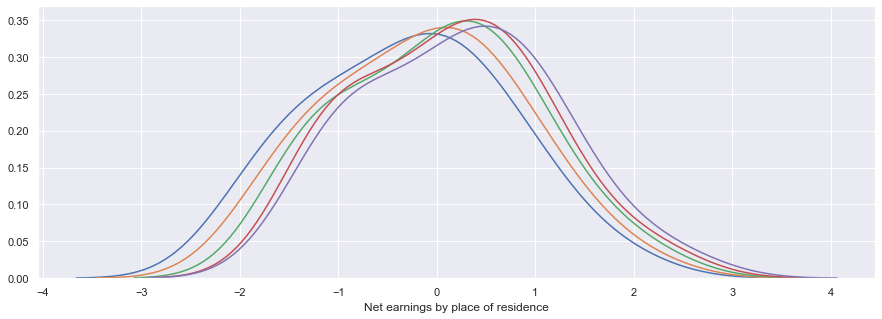

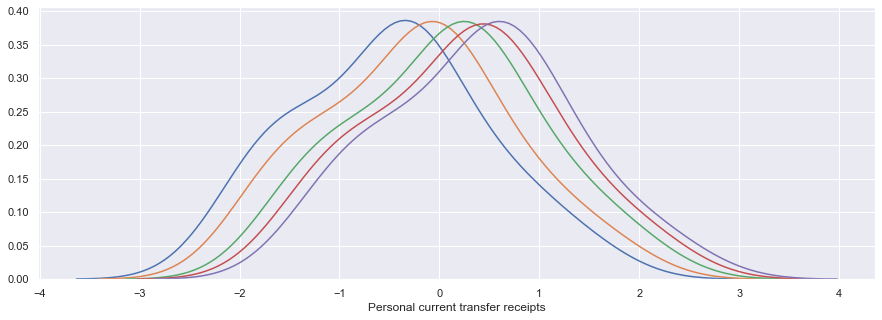

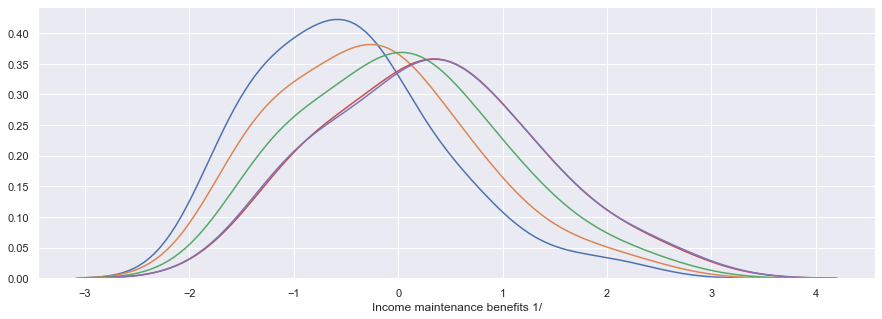

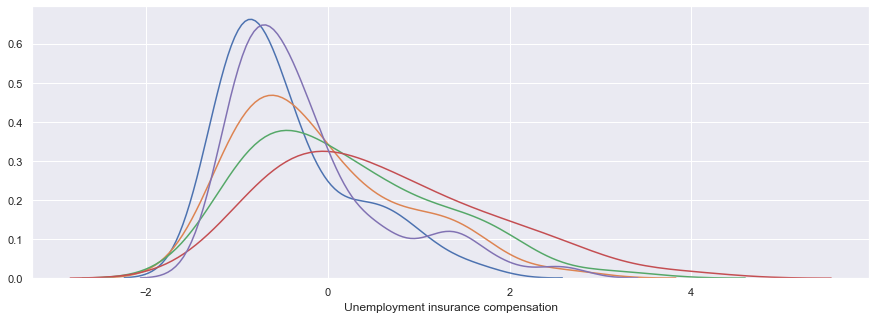

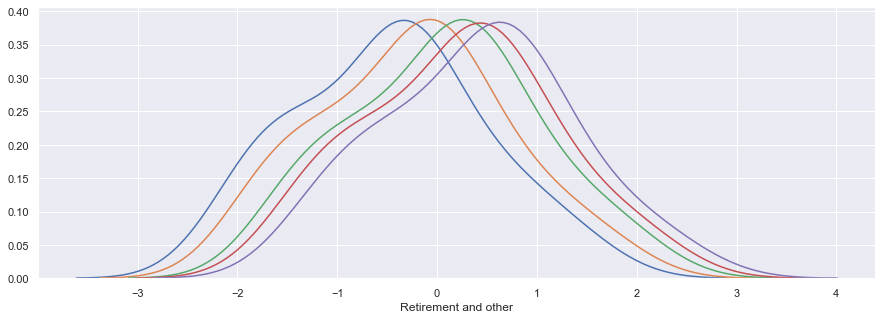

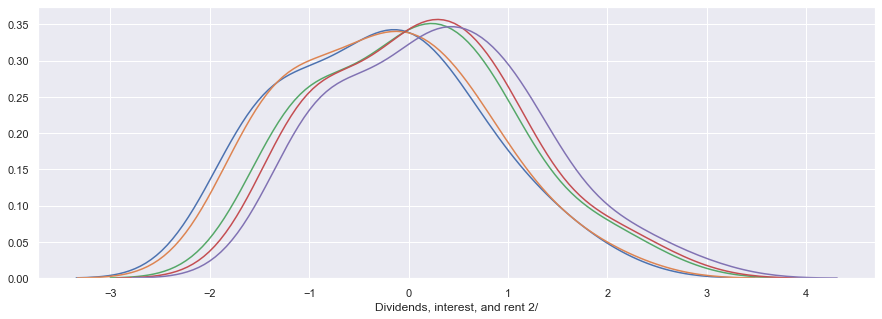

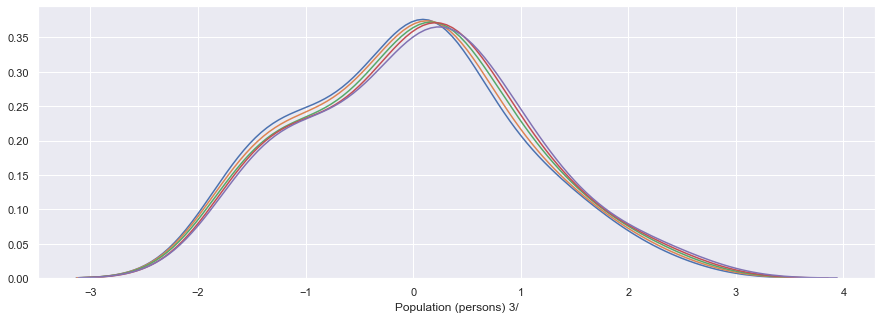

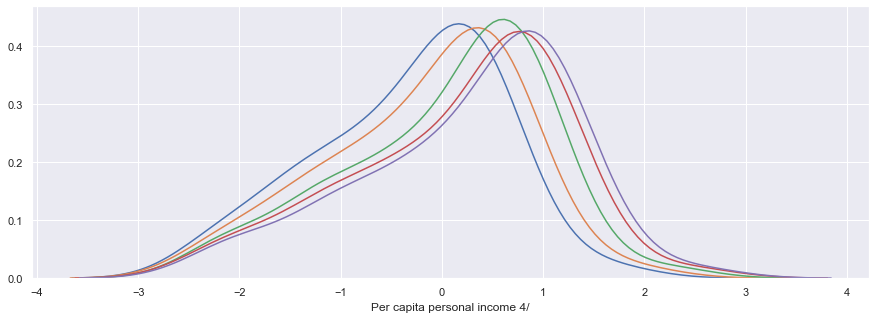

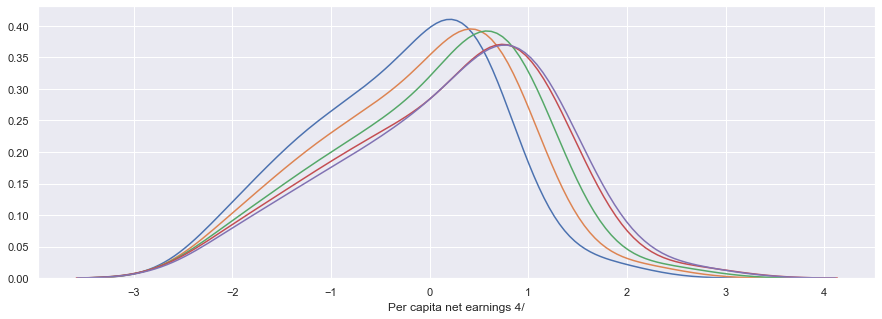

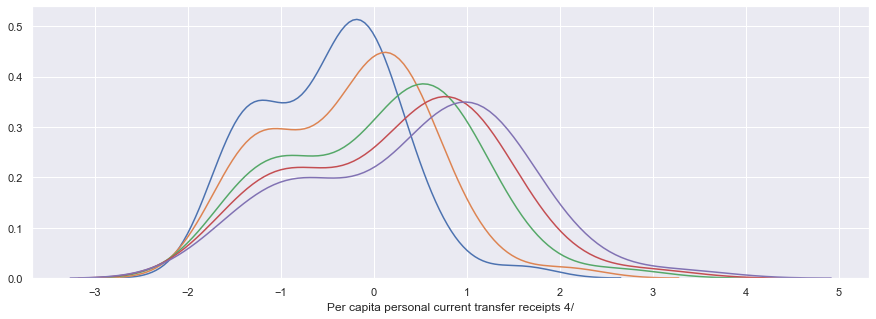

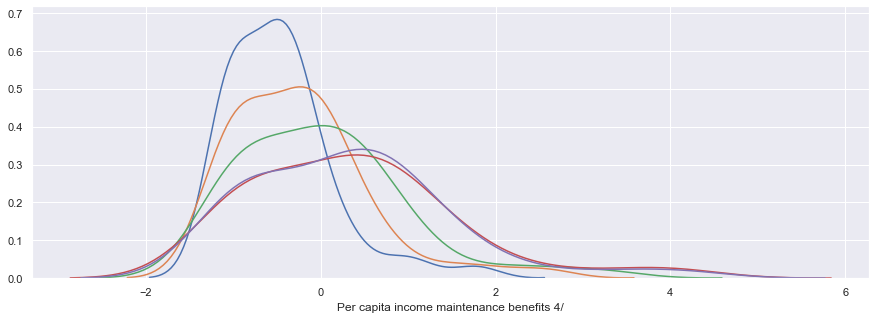

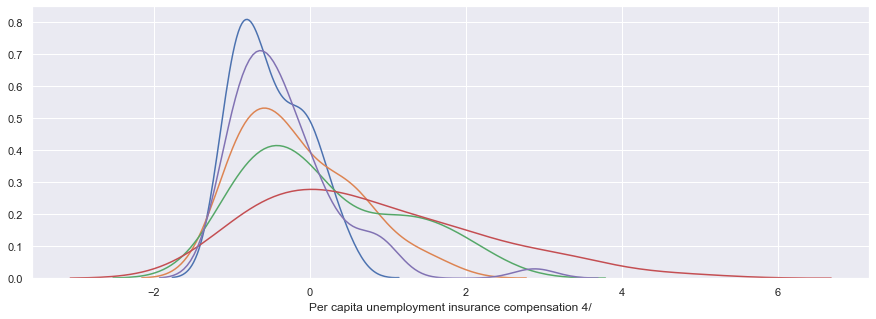

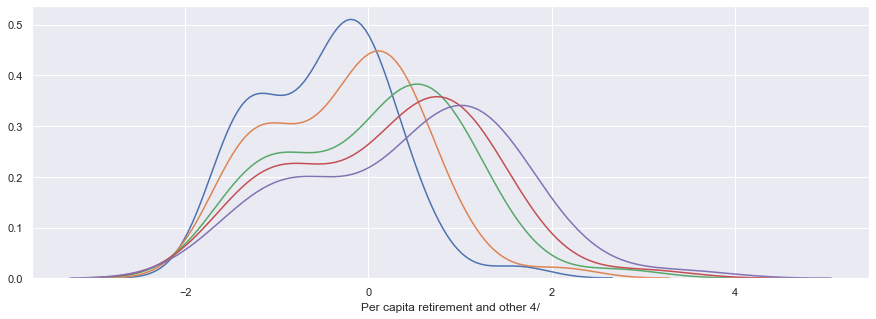

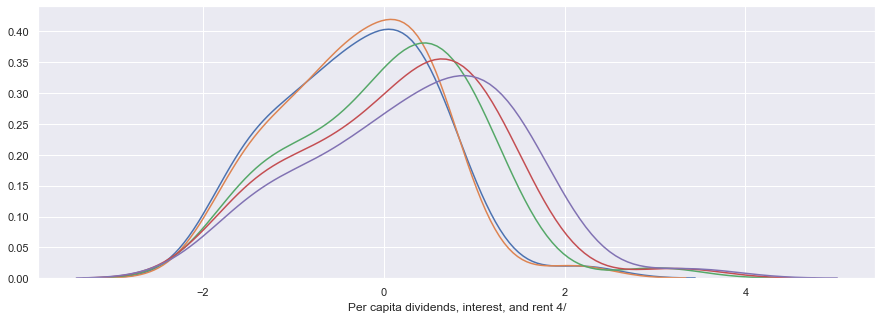

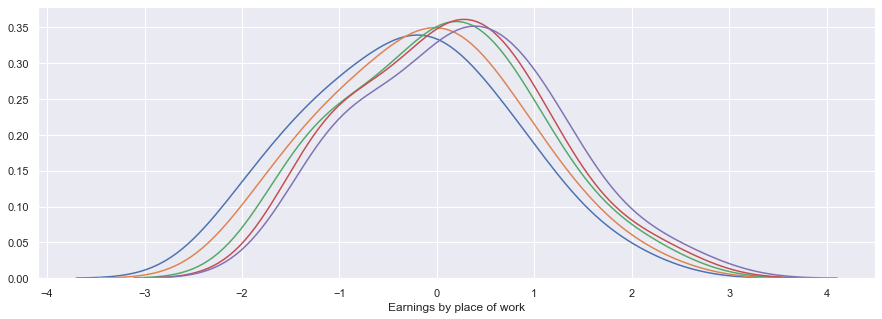

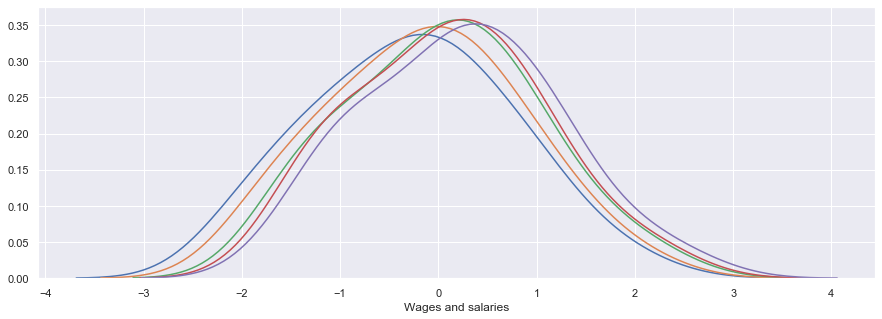

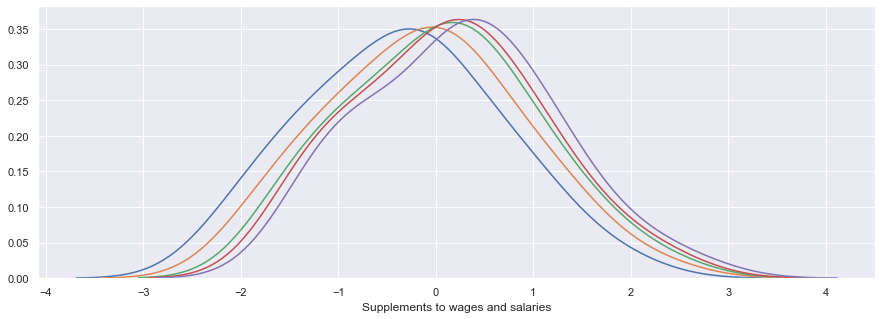

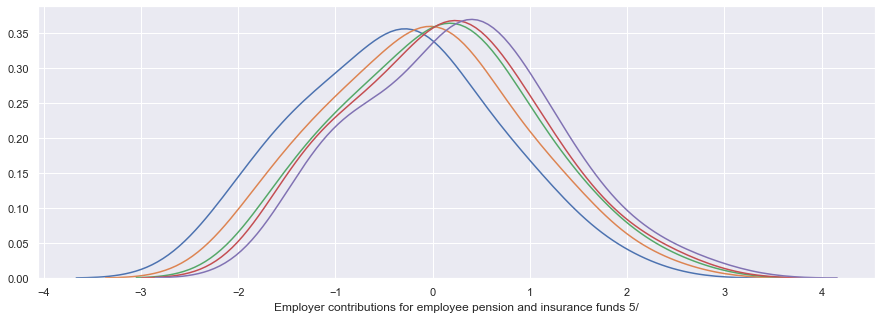

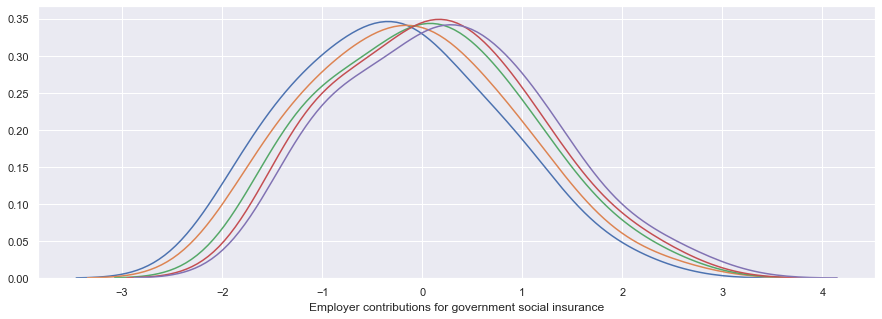

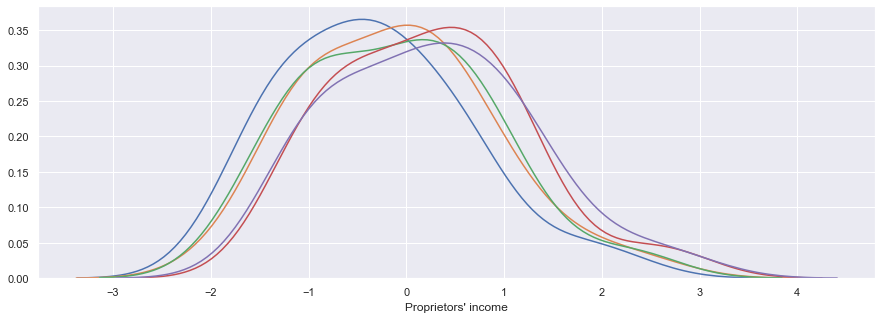

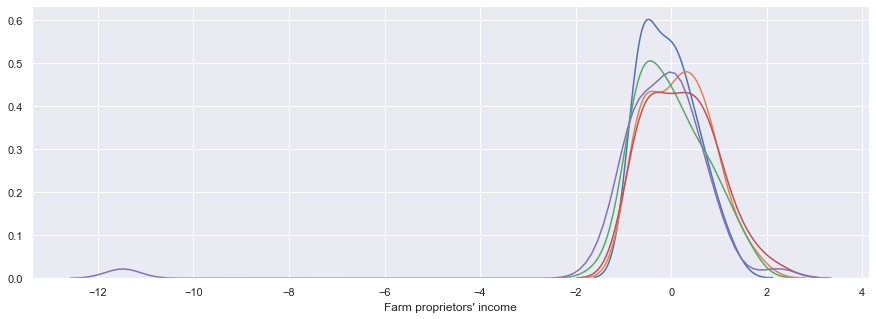

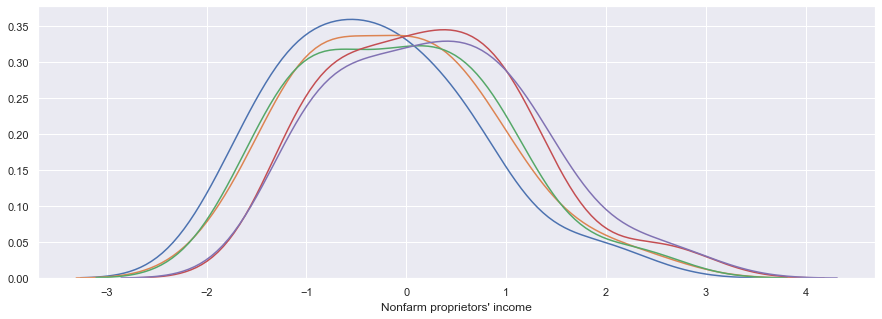

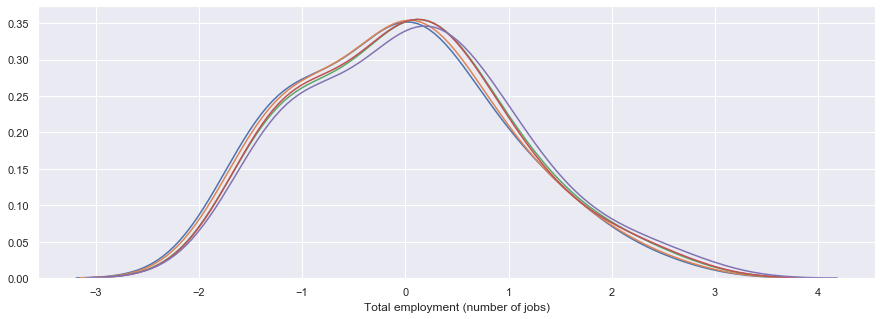

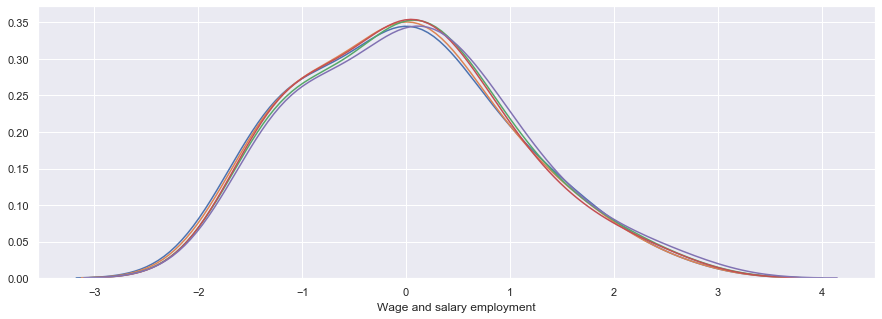

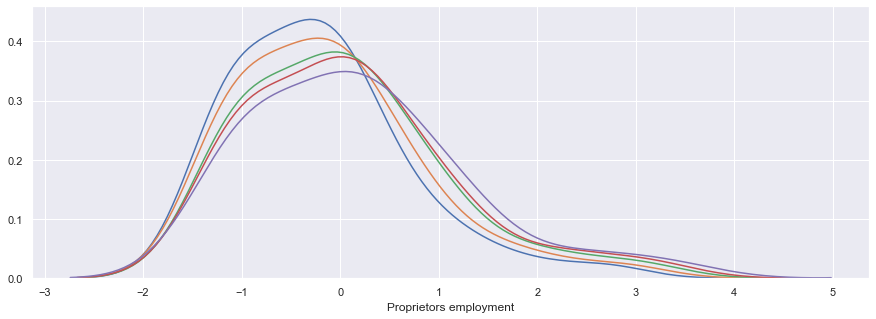

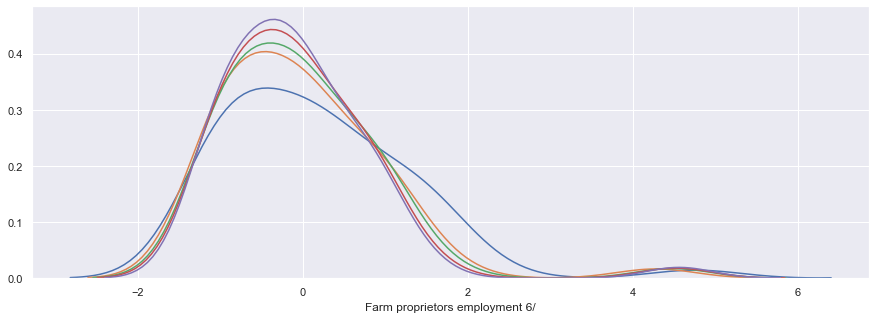

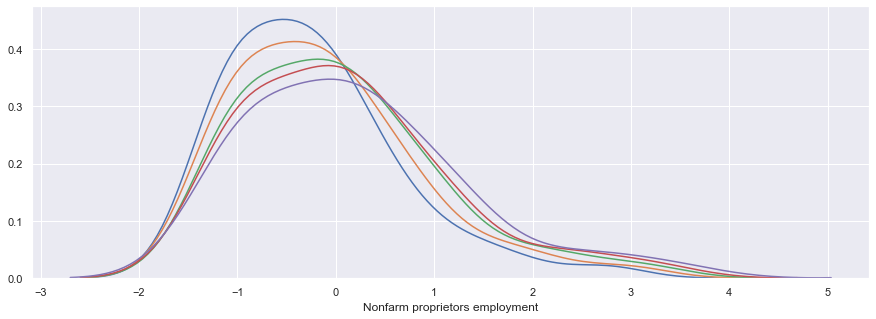

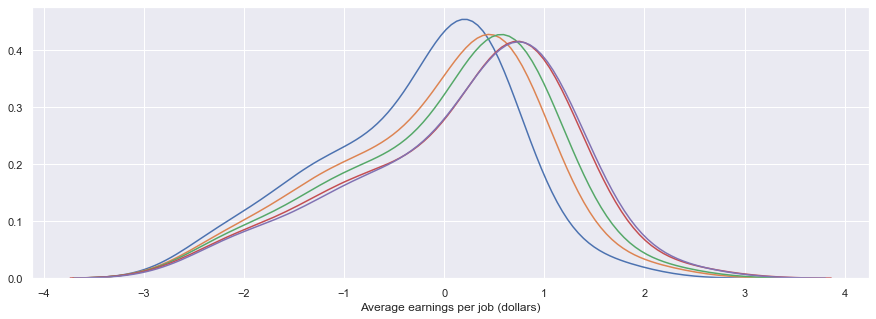

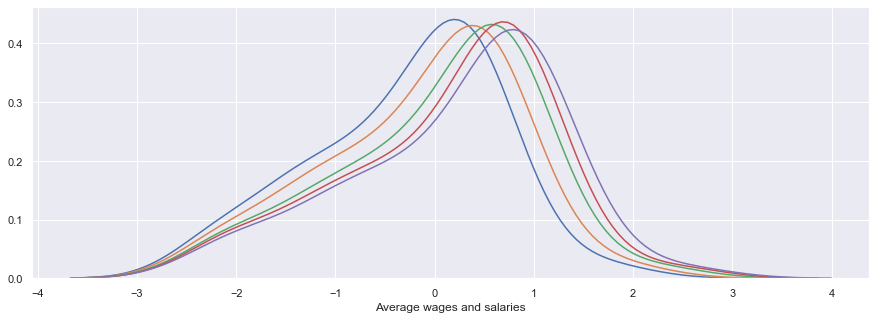

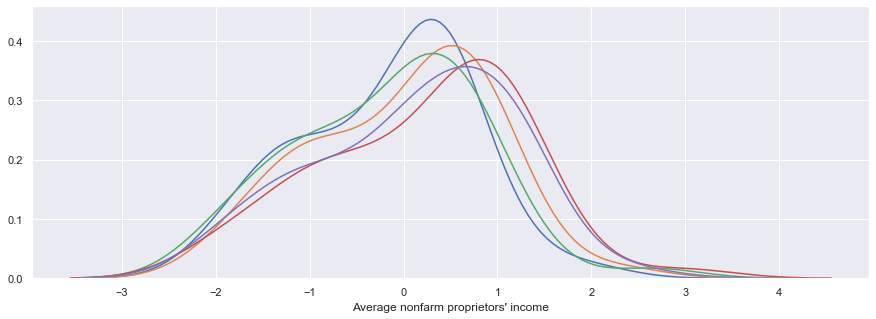

In [6]:
for col in num_cols:
    plt.figure(figsize=(15, 5))
    sns.distplot(df[col][df['year'] == 2000], hist=False)
    sns.distplot(df[col][df['year'] == 2004], hist=False)
    sns.distplot(df[col][df['year'] == 2008], hist=False)
    sns.distplot(df[col][df['year'] == 2012], hist=False)
    sns.distplot(df[col][df['year'] == 2016], hist=False)

In [7]:
cols2use = ['winner',
            'Income maintenance benefits 1/',
            'Unemployment insurance compensation',
            'Retirement and other',
            'Per capita personal income 4/',
            'Per capita net earnings 4/',
            'Per capita personal current transfer receipts 4/',
            'Per capita income maintenance benefits 4/',
            'Per capita unemployment insurance compensation 4/',
            'Per capita retirement and other 4/',
            'Per capita dividends, interest, and rent 4/',
            "Nonfarm proprietors' income",
            'Farm proprietors employment 6/',
            'Average earnings per job (dollars)',
            'Average wages and salaries',
            "Average nonfarm proprietors' income"]

data = df[df.columns.difference(['year', 'state',
                                 'republican',
                                 'democrat',
                                 'total_votes'])].values
data = df[cols2use].values
row_years = dict(zip(df['year'].unique(),
                     map(lambda x: df[df['year'] == x].index,
                         df['year'].unique())))

data_per_year = list(map(lambda x: data[x, :], list(row_years.values())))

In [8]:
df_states = pd.read_csv('https://raw.githubusercontent.com/' +
                        'plotly/datasets/master/' +
                        '2011_us_ag_exports.csv')[['code', 'state']]
df_states = df_states.merge(df[['state', 'year','winner']], on='state', how='inner')

fig = go.Figure(data=go.Choropleth(
    locations=df_states[df_states['year'] == 2000]['code'], # Spatial coordinates
    z = df_states[df_states['year'] == 2000]['winner'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = ["#0000ff", "#ff0000"],
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

### Mapper
#### SVD Filter

In [9]:
n_components = 1

nintervals = 7
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(0.2)

filtr = SvdFilter(n_components=n_components)

##### 2000

In [10]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

In [11]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

In [12]:
def get_state_plot_data(data, mapper, df, col, cmap):
    map_col = (pd.DataFrame(np.zeros((data.shape[0],
                                      2)),
                            columns=['color_sum', 'n_states']))

    for rows, val in zip(list(map(lambda x: x._labels.tolist(),
                                  dict(mapper._nodes.items()).values())),
                         get_mean_node(mapper, df=df,
                                       col=col)):
        map_col.loc[rows] = map_col.loc[rows] + [val, 1]

    colors = list(map(lambda x: matplotlib.colors.rgb2hex(x),
                      cmap((map_col['color_sum'] /
                            map_col['n_states']).unique().tolist())[:, :3]))

    return ((map_col['color_sum'] / map_col['n_states']).tolist(),
            colors)

In [13]:
values, color = get_state_plot_data(data_per_year[0], mapper, df, 'winner', cmap)
df_states = pd.read_csv('https://raw.githubusercontent.com/' +
                        'plotly/datasets/master/' +
                        '2011_us_ag_exports.csv')[['code', 'state']]
df_states = df_states.merge(df[['state', 'year','winner']], on='state', how='inner')

fig = go.Figure(data=go.Choropleth(
    locations=df_states[df_states['year'] == 2000]['code'], # Spatial coordinates
    z = values, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = color,
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

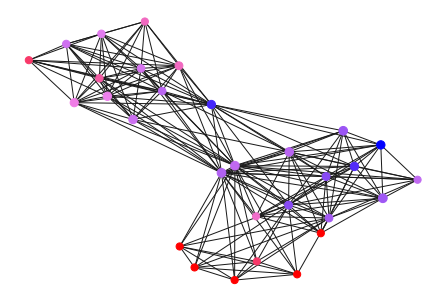

In [14]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2004

In [15]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

In [16]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

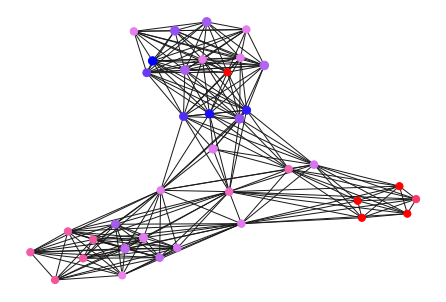

In [17]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2008

In [18]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

In [19]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

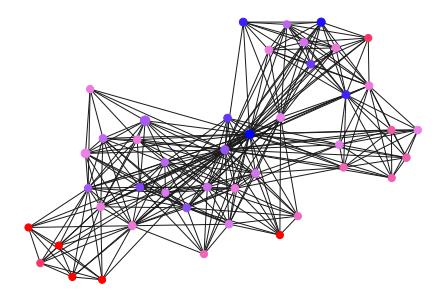

In [20]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2012

In [21]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[3])
mapper.fit(verbose=0)

In [22]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

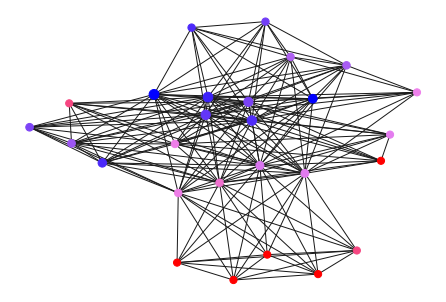

In [23]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2016

In [24]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[4])
mapper.fit(verbose=0)

In [25]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

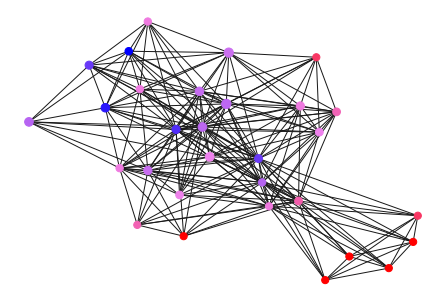

In [26]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

<hr style="border: 1px dashed rgb(255,255,255)" color=rgb(0,0,0) size="6">

#### Projection

In [27]:
df['perc'] = df['republican'] / df['total_votes']

In [28]:
ax = 11

nintervals = 10
overlap = 0.9

method = 'complete'
metric = 'correlation'
cutoff = FirstGap(.3)

filtr = Projection(ax=ax)

##### 2000

In [29]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[0])
mapper.fit(verbose=0)

In [30]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

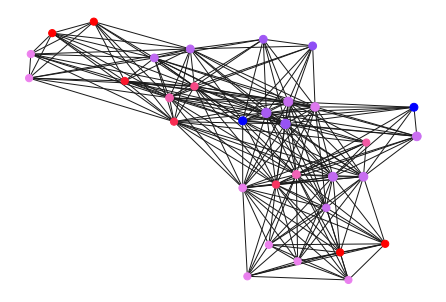

In [31]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

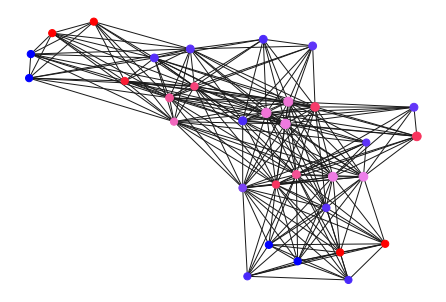

In [32]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='perc'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2004

In [33]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[1])
mapper.fit(verbose=0)

In [34]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

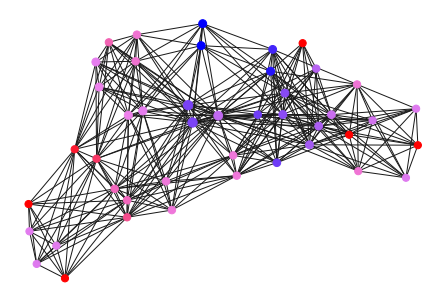

In [35]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

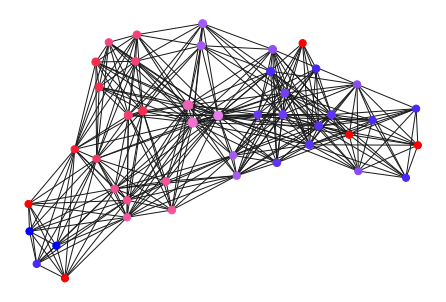

In [36]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='perc'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2008

In [37]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[2])
mapper.fit(verbose=0)

In [38]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

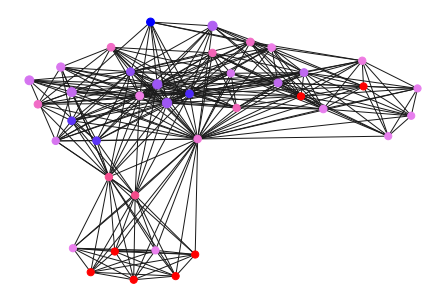

In [39]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

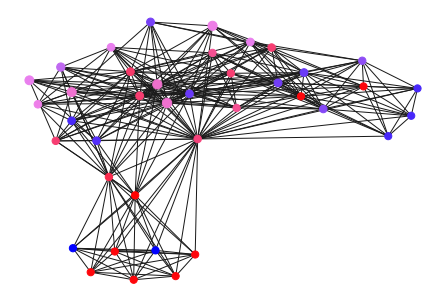

In [40]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='perc'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2012

In [41]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[3])
mapper.fit(verbose=0)

In [42]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

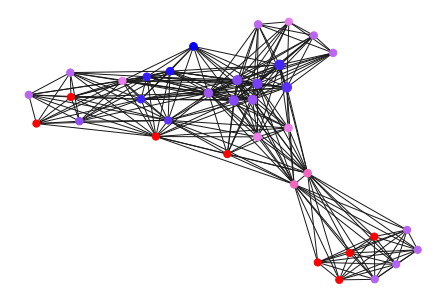

In [43]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

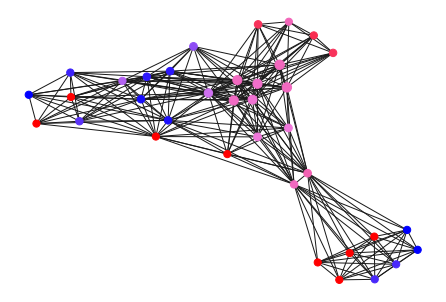

In [44]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='perc'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

##### 2016

In [45]:
mapper = get_mapper(filtr, nintervals, overlap, method,
                    metric, cutoff, data_per_year[4])
mapper.fit(verbose=0)

In [46]:
col = 'winner'
pos = nx.spring_layout(mapper.complex._graph, seed=0)
size = list(map(lambda x: 12 + x / min(get_node_size(mapper)),
                get_node_size(mapper)))
node_text = []
for node, pct in zip(list(dict(mapper._nodes.items()).values()),
                     get_mean_node(mapper, df=df, col=col)):
        node_text.append(f'# of counties: {len(node._labels)}<br>' +
                         f'Percentage voted for republican: {round(100 * pct, 2)}')
node_color = get_mean_node(mapper, df=df, col=col)

mapper_plotly_plot(mapper, df, pos, size, node_color, node_text, col='winner',
                   colorscale='RdBu', title='Percentage voted for republican')

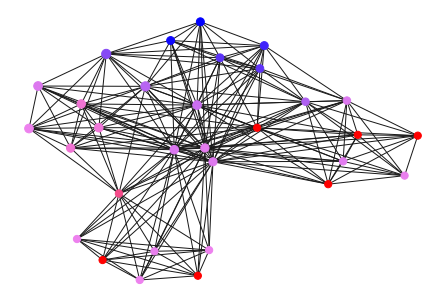

In [47]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='Per capita net earnings 4/'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))

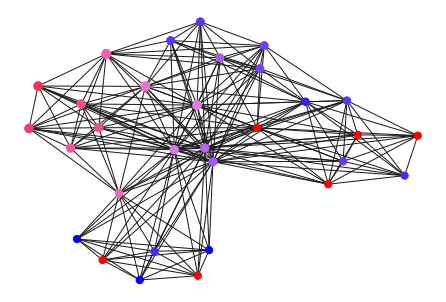

In [48]:
mapper_nx_plot(mapper, cmap=cmap,
               node_color=get_mean_node(mapper,
                                        df=df,
                                        col='perc'),
               node_size=get_node_size(mapper),
               pos=nx.spring_layout(mapper.complex._graph, seed=0))